In [12]:
#importamos las librerias necesarias
import numpy as np #manipulacion matematica
import pyeeg as pe #funciones para frecuencia, especificamente en eeg
import pickle as pickle #para descomprimir archivos
import pandas as pd #manipulacion de dataframes
import math #math
import matplotlib.pyplot as plt
import mne
from scipy import stats as st
from statistics import mean
from scipy import signal
from pythonosc import udp_client
from statistics import mean
from PIL import Image
import random

from sklearn import svm #importamos suport vector machine para probar el modelo
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize, LabelEncoder #normalizacion de datos
from sklearn.ensemble import RandomForestRegressor #random forest para prediccion de datos
from sklearn.ensemble import RandomForestClassifier #random forest para prediccion de datos
from sklearn.ensemble import AdaBoostRegressor #modelo para prediccion

import os #comunicacion con equipo operativo
#import tensorflow as tf
import time #control de tiempo

import warnings
from sklearn.exceptions import DataConversionWarning

In [13]:
def mode(ls):
    # dictionary to keep count of each value
    counts = {}
    # iterate through the list
    for item in ls:
        if item in counts:
            counts[item] += 1
        else:
            counts[item] = 1
    # get the keys with the max counts
    return [key for key in counts.keys() if counts[key] == max(counts.values())]

In [14]:
#cargar los datos
filepath = 's01.bdf' #cambien a su filepath
raw = mne.io.read_raw_bdf(filepath)

#elegimos los canales que queramos
channels_names=['Fp1', 'Fp2', 'C3','C4', 'P7', 'P8','O1', 'O2']
raw.pick_channels(channels_names)

#resampleo
raw = raw.resample(128)

#filtrado
raw = raw.filter(4,45)

#rereferenciado
ref = 'average'
raw = raw.set_eeg_reference(ref_channels=ref)

df = raw.to_data_frame(picks=list(range(raw.info['nchan'])))

Extracting EDF parameters from c:\Users\migue\Documents\GitHub\NH\s01.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 213 samples (1.664 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s finished


In [15]:
df = df[['Fp1','Fp2','C3','C4', 'P7','P8','O1','O2']]

#bandas
delta = raw.copy().filter(0.5, 4, method='iir', picks='eeg')
theta = raw.copy().filter(4, 8, method='iir', picks='eeg')
alpha = raw.copy().filter(8, 13, method='iir', picks='eeg')
beta = raw.copy().filter(13, 30, method='iir', picks='eeg')
gamma = raw.copy().filter(30, 45, method='iir', picks='eeg')

delta_data = delta.get_data()
theta_data = theta.get_data()
alpha_data = alpha.get_data()
beta_data = beta.get_data()
gamma_data = gamma.get_data()

channel_names = raw.ch_names

#data frame para cada banda de frecuencia
delta_df = pd.DataFrame(delta_data.T, columns=channel_names).rename(columns={'Fp1':'Fp1_Delta', 'Fp2':'Fp2_Delta', 'C3':'C3_Delta','C4':'C4_Delta', 'P7':'P7_Delta', 'P8':'P8_Delta','O1':'O1_Delta', 'O2':'O2_Delta'})
theta_df = pd.DataFrame(theta_data.T, columns=channel_names).rename(columns={'Fp1':'Fp1_Theta', 'Fp2':'Fp2_Theta', 'C3':'C3_Theta','C4':'C4_Theta', 'P7':'P7_Theta', 'P8':'P8_Theta','O1':'O1_Theta', 'O2':'O2_Theta'})
alpha_df = pd.DataFrame(alpha_data.T, columns=channel_names).rename(columns={'Fp1':'Fp1_Alpha', 'Fp2':'Fp2_Alpha', 'C3':'C3_Alpha','C4':'C4_Alpha', 'P7':'P7_Alpha', 'P8':'P8_Alpha','O1':'O1_Alpha', 'O2':'O2_Alpha'})
beta_df = pd.DataFrame(beta_data.T, columns=channel_names).rename(columns={'Fp1':'Fp1_Beta', 'Fp2':'Fp2_Beta', 'C3':'C3_Beta','C4':'C4_Beta', 'P7':'P7_Beta', 'P8':'P8_Beta','O1':'O1_Beta', 'O2':'O2_Beta'})
gamma_df = pd.DataFrame(gamma_data.T, columns=channel_names).rename(columns={'Fp1':'Fp1_Gamma', 'Fp2':'Fp2_Gamma', 'C3':'C3_Gamma','C4':'C4_Gamma', 'P7':'P7_Gamma', 'P8':'P8_Gamma','O1':'O1_Gamma', 'O2':'O2_Gamma'})

df2 = pd.concat([delta_df, theta_df, alpha_df, beta_df, gamma_df], axis=1)
df3 = df2*2000000

cols = ['Fp1_Delta', 'Fp1_Theta', 'Fp1_Alpha','Fp1_Beta','Fp1_Gamma',
        'Fp2_Delta', 'Fp2_Theta', 'Fp2_Alpha','Fp2_Beta','Fp2_Gamma',
        'C3_Delta', 'C3_Theta', 'C3_Alpha','C3_Beta','C3_Gamma',
        'P7_Delta', 'P7_Theta', 'P7_Alpha','P7_Beta','P7_Gamma',
        'P8_Delta', 'P8_Theta', 'P8_Alpha','P8_Beta','P8_Gamma',
        'O1_Delta', 'O1_Theta', 'O1_Alpha','O1_Beta','O1_Gamma',
        'O2_Delta', 'O2_Theta', 'O2_Alpha','O2_Beta','O2_Gamma',] #'C4_Delta', 'C4_Theta', 'C4_Alpha','C4_Beta','C4_Gamma',
df3 = df3[cols]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 4 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 4.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 13.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-pass

In [16]:
def valores(data):
    if data <= 3.6:
        data = 0
    elif data > 3.6 and data < 6.3:
        data = 1
    else:
        data = 2
    return data

In [17]:
Val_Pkl = pickle.load(open('Models/Val_R2.pkl', 'rb'))
Aro_Pkl = pickle.load(open('Models/Aro_R2.pkl', 'rb'))
Dom_Pkl = pickle.load(open('Models/Dom_R2.pkl', 'rb'))

In [18]:
# definir high, low, med
def emocion(valence, arousal, dominance):
    if valence == 0:
        if arousal == 0:
            if dominance == 0:
                image = Image.open('img\Sadness_'+ str(random.randint(1, 4))+'.jfif')
                plt.imshow(image)
                return 'Sadness'
                
            elif dominance == 1:
                return 'Other'

            elif dominance == 2:
                image = Image.open('img\Rejection_'+ str(random.randint(1, 4))+'.jfif')
                plt.imshow(image)
                return 'Rejected'

        elif arousal == 1:
            if dominance == 0:
                return 'Other'

            elif dominance == 1:
                return 'Other'

            elif dominance == 2:
                image = Image.open('img\Calm_'+ str(random.randint(1, 4))+'.jfif')
                plt.imshow(image)
                return 'Calm'

        elif arousal == 2:
            if dominance == 0:
                image = Image.open('img\Relief_'+ str(random.randint(1, 4))+'.jfif')
                plt.imshow(image)
                return 'Relief'

            elif dominance == 1:
                image = Image.open('img\Relaxed_'+ str(random.randint(1, 4))+'.jfif')
                plt.imshow(image)
                return 'Relaxed'

            elif dominance == 2:
                image = Image.open('img\Overconfidence_'+ str(random.randint(1, 4))+'.jfif')
                plt.imshow(image)
                return 'Overconfident'         
    if valence == 1:
        if arousal == 0:
            if dominance == 0:
                return 'Other'

            elif dominance == 1:
                return 'Other'

            elif dominance == 2:
                image = Image.open('img\Pessimism_'+ str(random.randint(1, 4))+'.jfif')
                plt.imshow(image)
                return 'Pessimistic'

        elif arousal == 1:
            if dominance == 0:
                return 'Other'
                
            elif dominance == 1:
                image = Image.open(r'img\Neutral_'+ str(random.randint(1, 4))+'.jfif')
                plt.imshow(image)
                return 'Neutral'

            elif dominance == 2:
                return 'Other'

        elif arousal == 2:
            if dominance == 0:
                image = Image.open('img\Satisfaction_'+ str(random.randint(1, 4))+'.jfif')
                plt.imshow(image)
                return 'Sattisfied'

            elif dominance == 1:
                return 'Other'

            elif dominance == 2:
                return 'Other' 

    if valence == 2:
        if arousal == 0:
            if dominance == 0:
                image = Image.open('img\Hate_'+ str(random.randint(1, 4))+'.jfif')
                plt.imshow(image)
                return 'Hate'

            elif dominance == 1:
                image = Image.open('img\Distressed_'+ str(random.randint(1, 4))+'.jpeg')
                plt.imshow(image)
                return 'Distressed'

            elif dominance == 2:
                image = Image.open('img\Anxiety_'+ str(random.randint(1, 4))+'.jfif')
                plt.imshow(image)
                return 'Anxious'

        elif arousal == 1:
            if dominance == 0:
                image = Image.open('img\Admiration_'+ str(random.randint(1, 4))+'.jpeg')
                plt.imshow(image)
                return 'Admiration'

            elif dominance == 1:
                image = Image.open('img\Desire_'+ str(random.randint(1, 7))+'.jpeg')
                plt.imshow(image)
                return 'Desire'

            elif dominance == 2:
                return 'Other'

        elif arousal == 2:
            if dominance == 0:
                image = Image.open('img\Love_'+ str(random.randint(1, 7))+'.jpeg')
                plt.imshow(image)
                return 'Love'

            elif dominance == 1:
                image = Image.open('img\Joy_'+ str(random.randint(1, 4))+'.jpeg')
                plt.imshow(image)
                return 'Joy'

            elif dominance == 2:
                image = Image.open('img\Generosity_'+ str(random.randint(1, 4))+'.jpeg')
                plt.imshow(image)
                return 'Generosity'   

In [19]:
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=DataConversionWarning)

Valence = 0
Arousal = 2
Dominance = 1
Feliz Cumple Mar!
Relaxed


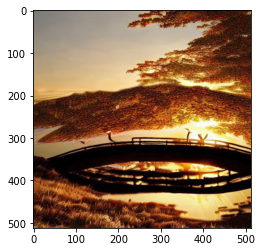

In [29]:
init = 351
end = init+1
valen = Val_Pkl.predict(df3[(512*init):(512*end):512])
arous = Aro_Pkl.predict(df3[(512*init):(512*end):512])
domin = Dom_Pkl.predict(df3[(512*init):(512*end):512])
vale = mean(valen)
arou = mean(arous)
domi = mean(domin)
print('Valence =',vale)
print('Arousal =',arou)
print('Dominance =',domi)
emociones = emocion(vale, arou, domi)
print(emociones)

In [21]:
'''ip = "10.22.178.244"  # IP address of the receiving device
port = 8001  # Port number of the receiving device

client = udp_client.SimpleUDPClient(ip, port)

address = "/example/address"  # OSC address to send the message to

client.send_message(address, valence_class)
client.send_message(address, arousal_class)
client.send_message(address, dominance_class)
client.send_message(address, emociones)''' 

'ip = "10.22.178.244"  # IP address of the receiving device\nport = 8001  # Port number of the receiving device\n\nclient = udp_client.SimpleUDPClient(ip, port)\n\naddress = "/example/address"  # OSC address to send the message to\n\nclient.send_message(address, valence_class)\nclient.send_message(address, arousal_class)\nclient.send_message(address, dominance_class)\nclient.send_message(address, emociones)'